# Pre-processing of Multi-label Classification Model Need-Project tweets
# For one region - 'Downtown' or all regions

In [384]:
# Import modules
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection._split import StratifiedShuffleSplit
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.svm.classes import SVC, LinearSVC


import nltk
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pylab as plt



In [385]:

#for showing plot in jupyter
%matplotlib inline 

In [386]:
# read english file. The needs_tweets.csv has 15379 rows, while needs_tweets_eng.csv has 9026 rows
is_all_regions = True
# file_name_input = "needs_tweets_eng.csv"
file_name_input = "needs_tweets_eng.csv"
if is_all_regions:
    file_name_output = 'needs_tweets_eng_processed_all_regions.csv'
else:
    file_name_output = 'needs_tweets_eng_processed_eng_one_region.csv'



data_df = pd.read_csv(file_name_input, delimiter=',', encoding = "ISO-8859-1")
print('len data_df including null values', len(data_df))
# data_df.head()
#removing NaN or empty multi_class_label rows
data_df = data_df.dropna()
data_df.head()

len data_df including null values 14887


,tweet_text,region_name,tweet_date_time,multi_class_label
5,"Models need to eat too. ""Always Hungry"" thank...",Willowbrook,Wed Aug 23 00:15:39 CDT 2017,need
13,Still Comes Back Beige... Just #FollowTheSmel...,Greater Hobby Area,Wed Aug 23 00:54:51 CDT 2017,trail
14,We're #hiring! Click to apply: Service Technic...,Fourth Ward,Wed Aug 23 01:13:22 CDT 2017,service
32,Me and Bae paid our support to my cuz tonight ...,Independence Heights,Wed Aug 23 01:57:09 CDT 2017,support
56,Wings Over Water - Avenida Houston - Downtown ...,Mid West,Wed Aug 23 04:58:54 CDT 2017,water


In [387]:
len(data_df)

2865

In [388]:
# data_df

In [389]:
# extract 'hour' feature from 'tweet_date_time'

hours_list = [row['tweet_date_time'][11:13] for index, row in data_df.iterrows()]
for index, row in data_df.iterrows():
    dt = row['tweet_date_time']
#     print(dt[11:13])
# print(hours_list)
data_df['hour'] = hours_list
data_df.head()

,tweet_text,region_name,tweet_date_time,multi_class_label,hour
5,"Models need to eat too. ""Always Hungry"" thank...",Willowbrook,Wed Aug 23 00:15:39 CDT 2017,need,00
13,Still Comes Back Beige... Just #FollowTheSmel...,Greater Hobby Area,Wed Aug 23 00:54:51 CDT 2017,trail,00
14,We're #hiring! Click to apply: Service Technic...,Fourth Ward,Wed Aug 23 01:13:22 CDT 2017,service,01
32,Me and Bae paid our support to my cuz tonight ...,Independence Heights,Wed Aug 23 01:57:09 CDT 2017,support,01
56,Wings Over Water - Avenida Houston - Downtown ...,Mid West,Wed Aug 23 04:58:54 CDT 2017,water,04


In [390]:
#drop column 'tweet_date_time'
data_df = data_df.drop('tweet_date_time', axis=1)
data_df.head()

,tweet_text,region_name,multi_class_label,hour
5,"Models need to eat too. ""Always Hungry"" thank...",Willowbrook,need,00
13,Still Comes Back Beige... Just #FollowTheSmel...,Greater Hobby Area,trail,00
14,We're #hiring! Click to apply: Service Technic...,Fourth Ward,service,01
32,Me and Bae paid our support to my cuz tonight ...,Independence Heights,support,01
56,Wings Over Water - Avenida Houston - Downtown ...,Mid West,water,04


In [391]:
# select rows for one region = 'Downtown'
if not is_all_regions:
    data_df = data_df.loc[data_df['region_name'] == 'Downtown']

data_df.head()

,tweet_text,region_name,multi_class_label,hour
5,"Models need to eat too. ""Always Hungry"" thank...",Willowbrook,need,00
13,Still Comes Back Beige... Just #FollowTheSmel...,Greater Hobby Area,trail,00
14,We're #hiring! Click to apply: Service Technic...,Fourth Ward,service,01
32,Me and Bae paid our support to my cuz tonight ...,Independence Heights,support,01
56,Wings Over Water - Avenida Houston - Downtown ...,Mid West,water,04


In [392]:
#count needs

need_counts = dict() # a dictionary of all needs with counts for each a need
for row in data_df["multi_class_label"]:
    for item in row.split():# item=word
        if item in need_counts:
            need_counts[item] += 1
        else:
            need_counts[item] = 1        
need_counts

{'need': 271,
 'trail': 15,
 'service': 81,
 'support': 92,
 'water': 352,
 'school': 137,
 'nurse': 121,
 'store': 213,
 'family': 146,
 'help': 324,
 'supply': 36,
 'people': 209,
 'tank': 15,
 'call': 79,
 'emergency': 32,
 'food': 88,
 'community': 51,
 'gas': 23,
 'contact': 26,
 'home': 168,
 'oil': 14,
 'grocery': 20,
 'bottle': 6,
 'car': 35,
 'restaurant': 27,
 'dog': 25,
 'beer': 22,
 'power': 30,
 'money': 41,
 'text': 19,
 'donate': 99,
 'advisory': 10,
 'wine': 17,
 'safe': 158,
 'flood': 151,
 'truck': 25,
 'victim': 41,
 'rescue': 74,
 'cable': 5,
 'donation': 81,
 'fund': 13,
 'clothes': 18,
 'shelter': 54,
 'boat': 35,
 'damage': 22,
 'assistance': 11,
 'relief': 82,
 'volunteer': 61}

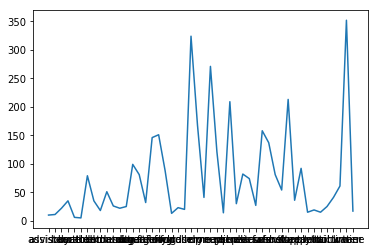

[('advisory', 10),
 ('assistance', 11),
 ('beer', 22),
 ('boat', 35),
 ('bottle', 6),
 ('cable', 5),
 ('call', 79),
 ('car', 35),
 ('clothes', 18),
 ('community', 51),
 ('contact', 26),
 ('damage', 22),
 ('dog', 25),
 ('donate', 99),
 ('donation', 81),
 ('emergency', 32),
 ('family', 146),
 ('flood', 151),
 ('food', 88),
 ('fund', 13),
 ('gas', 23),
 ('grocery', 20),
 ('help', 324),
 ('home', 168),
 ('money', 41),
 ('need', 271),
 ('nurse', 121),
 ('oil', 14),
 ('people', 209),
 ('power', 30),
 ('relief', 82),
 ('rescue', 74),
 ('restaurant', 27),
 ('safe', 158),
 ('school', 137),
 ('service', 81),
 ('shelter', 54),
 ('store', 213),
 ('supply', 36),
 ('support', 92),
 ('tank', 15),
 ('text', 19),
 ('trail', 15),
 ('truck', 25),
 ('victim', 41),
 ('volunteer', 61),
 ('water', 352),
 ('wine', 17)]

In [393]:
#plot need_counts

lists = sorted(need_counts.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()
lists

## deleting any row has a need where it's count  < 50

In [394]:
print(len(data_df))
min_need_counts = 50
drop_index_set = {-1}
for index, row in data_df.iterrows():
    found = False
    for item in row["multi_class_label"].split():

        if need_counts[item] < min_need_counts:
            found = True
    if found: 
        data_df.drop(index, inplace=True)
drop_index_set.remove(-1)

count = 0
for i in drop_index_set:
    if i < min_need_counts: count += i
    len_before = len(data_df)
print(count, len(data_df))

2865
0 2317


In [395]:
np.sum([need_counts[i] for i in need_counts if need_counts[i] < 10])

11

# After deleting rows of less frequent needs (<5)

In [396]:
#count needs

need_counts = dict() # a dictionary of all needs with counts for each a need
for row in data_df["multi_class_label"]:
    for item in row.split():# item=word
        if item in need_counts:
            need_counts[item] += 1
        else:
            need_counts[item] = 1        
need_counts

{'need': 221,
 'service': 81,
 'support': 86,
 'water': 328,
 'school': 134,
 'nurse': 117,
 'store': 200,
 'family': 139,
 'help': 284,
 'people': 194,
 'call': 62,
 'food': 65,
 'community': 48,
 'home': 160,
 'donate': 77,
 'safe': 151,
 'flood': 126,
 'rescue': 62,
 'donation': 73,
 'shelter': 46,
 'relief': 67,
 'volunteer': 56}

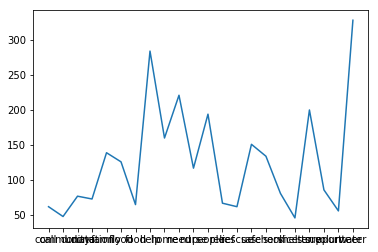

[('call', 62),
 ('community', 48),
 ('donate', 77),
 ('donation', 73),
 ('family', 139),
 ('flood', 126),
 ('food', 65),
 ('help', 284),
 ('home', 160),
 ('need', 221),
 ('nurse', 117),
 ('people', 194),
 ('relief', 67),
 ('rescue', 62),
 ('safe', 151),
 ('school', 134),
 ('service', 81),
 ('shelter', 46),
 ('store', 200),
 ('support', 86),
 ('volunteer', 56),
 ('water', 328)]

In [397]:
#plot need_counts

lists = sorted(need_counts.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()
lists

In [398]:
# data_df.drop(data_df.multi_class_label=='donation')
# data_df[data_df['multi_class_label']=='donation']

In [399]:
# split multi_class_label when there is two or more needs (i.e, a need has a space)
multi_class_label_list = []
multi_class_label_set = {'$$'} #unique values of needs as set
for l in data_df['multi_class_label']:
    l_set = {'$$'}
#     for item in l:
#         l_set.update(item.split(' '))
    l_set.update(l.split(' '))

    l_set.remove('$$')
    multi_class_label_set.update(l_set)
#     print(l_set)
#     print(' '.join(l_set))
    multi_class_label_list.append(l_set)
    
multi_class_label_set.remove('$$')
multi_class_label_all_unique = list(multi_class_label_set) #unique values of needs as list
data_df['multi_class_label'] = multi_class_label_list
data_df.head()

,tweet_text,region_name,multi_class_label,hour
5,"Models need to eat too. ""Always Hungry"" thank...",Willowbrook,{need},00
14,We're #hiring! Click to apply: Service Technic...,Fourth Ward,{service},01
32,Me and Bae paid our support to my cuz tonight ...,Independence Heights,{support},01
56,Wings Over Water - Avenida Houston - Downtown ...,Mid West,{water},04
57,Up to 54% Off Haircut Packages at Paul Mitchel...,Independence Heights,{school},05


In [400]:
multi_class_label_all_unique

['family',
 'shelter',
 'volunteer',
 'donation',
 'service',
 'store',
 'food',
 'rescue',
 'community',
 'flood',
 'call',
 'school',
 'nurse',
 'home',
 'donate',
 'safe',
 'relief',
 'need',
 'people',
 'support',
 'help',
 'water']

In [401]:
#convert multi_class_label_list column to 0 and 1

# multi_class_label_all_unique
multi_class_label_vec = []
need_counts = dict() # a dictionary of all needs with counts for each a need
for index, row in data_df.iterrows():
    class_vec = np.zeros(len(multi_class_label_all_unique), dtype=int)    
    for item in row["multi_class_label"]:# item=word
        i = multi_class_label_all_unique.index(item)
        class_vec[i] = 1
        #for need_counts
        if item in need_counts:
            need_counts[item] += 1
        else:
            need_counts[item] = 1        
#     print(row["multi_class_label_list"], class_vec)  
#     ss = ''
#     for s in class_vec:
#         ss = ss + ',' + str(s)
#     print(ss)
#     multi_class_label_vec.append(' '.join(str(s) for s in class_vec))
    multi_class_label_vec.append(', '.join(str(s) for s in class_vec))


#     multi_class_label_vec.append(ss)

data_df['multi_class_label_vec'] = multi_class_label_vec
data_df.head()

,tweet_text,region_name,multi_class_label,hour,multi_class_label_vec
5,"Models need to eat too. ""Always Hungry"" thank...",Willowbrook,{need},00,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
14,We're #hiring! Click to apply: Service Technic...,Fourth Ward,{service},01,"0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
32,Me and Bae paid our support to my cuz tonight ...,Independence Heights,{support},01,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
56,Wings Over Water - Avenida Houston - Downtown ...,Mid West,{water},04,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
57,Up to 54% Off Haircut Packages at Paul Mitchel...,Independence Heights,{school},05,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0..."


In [402]:
# convert multi_class_label from set to string
multi_class_label_string = []
for item in data_df['multi_class_label']:
#     print(' '.join(l))
    multi_class_label_string.append(' '.join(item))
multi_class_label_string
data_df['multi_class_label'] = multi_class_label_string
data_df.head()

,tweet_text,region_name,multi_class_label,hour,multi_class_label_vec
5,"Models need to eat too. ""Always Hungry"" thank...",Willowbrook,need,00,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
14,We're #hiring! Click to apply: Service Technic...,Fourth Ward,service,01,"0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
32,Me and Bae paid our support to my cuz tonight ...,Independence Heights,support,01,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
56,Wings Over Water - Avenida Houston - Downtown ...,Mid West,water,04,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
57,Up to 54% Off Haircut Packages at Paul Mitchel...,Independence Heights,school,05,"0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0..."


In [403]:
data_df.to_csv(file_name_output, sep='\t', index=False,encoding='utf-8')

In [404]:
len(data_df)

2317